In [11]:
class World:
    def __init__(self,Length,Width,radius,L):
        self.Length = Length
        self.Width = Width
        self.radius = radius
        self.L = L

        
class car_simulation(DistanceGenerator):
    def __init__(self,r,phi_1,phi_2, L):
        self.theta_t_measured = 0
        self.x_t_measured = 0
        self.y_t_measured = 0
        self.omega_t_measured = 0
        #self.X = np.zeros((6,1))
        self.r = r
        self.phi_1 = phi_1
        self.phi_2 = phi_2
        self.L = L
        self.sensor_simulation = np.zeros((4,1))
        self.distance_one = 0
        self.distance_two = 0
    def get_simulation(self):
        #change standard deviation
        #make them global? thetas?
        # get t.. t = t + something?
        w_omega_t = np.random.normal(0,0.66)
        w_v_t = np.random.normal(0,0.66)
        w_t = ((self.r*self.phi_1) - (self.r*self.phi_2))/self.L
        v_t = ((self.r*self.phi_1) + (self.r*self.phi_2))/2
        #time evolution
        self.theta_t_measured = self.theta_t_measured + ((w_t + w_omega_t) * dt)
        self.x_t__measured = self.x_t_measured + ((v_t + w_v_t) * math.cos(self.theta_t_measured) * dt)
        self.y_t_measured = self.y_t_measured + ((v_t + w_v_t) * math.sin(self.theta_t_measured) * dt)
        v_measured = v_t + w_v_t
        omega_measured = w_t + w_omega_t
        #self.X = [self.x_t_measured,self.y_t_measured,v_measured,self.theta_t_measured,omega_measured,0]
        #
        X = np.zeros((6,1))
        X[0][0] = self.x_t_measured
        X[1][0] = self.y_t_measured
        X[2][0] = v_measured
        X[3][0] = self.theta_t_measured
        X[4][0] = omega_measured
        X[5][0] = 0
        ###
        #print(self.X)
        temp = X
        #listl.append(temp)
        return temp
    def get_sensor_simulation(self):
        D1 = DistanceGenerator(self.x_t_measured, self.y_t_measured, self.theta_t_measured)
        D2 = DistanceGenerator(self.x_t_measured, self.y_t_measured, self.theta_t_measured + np.pi)
        self.distance_one = D1.laser_output() + np.random.normal(0, .04)
        self.distance_two = D2.laser_output() + np.random.normal(0, .04)
        self.theta_t_measured = self.theta_t_measured + np.random.normal(0, .001)
        self.omega_t_measured = self.omega_t_measured + np.random.normal(0, .001)
        #self.sensor_simulation = [self.distance_one, self.distance_two, self.theta, self.omega]
        #
        self.sensor_simulation[0][0] = self.distance_one
        self.sensor_simulation[1][0] = self.distance_two
        self.sensor_simulation[2][0] = self.theta_t_measured
        self.sensor_simulation[3][0] = self.omega_t_measured
        #
        return(self.sensor_simulation)

    
class EKF(car_simulation):
    def __init__(self,phi_1,phi_2,dt,L,Q,R,r):
        self.dt = dt
        #self.intial_state = intial_state
        #self.d = d
        #self.phi = phi
        self.phi_1 = phi_1
        self.phi_2 = phi_2
        self.X_cap = np.zeros((6,1))
        self.omega_t = ((r*phi_1) - (r*phi_2))/L
        self.v_t = ((r*phi_1) + (r*phi_2))/2
        self.X_bar = np.zeros((6,1))
        self.F_t = np.zeros((6,6))
        self.W_t = np.zeros((6,2))
        self.sigma_cap = np.zeros((6,6))#check
        self.H_t = np.zeros((4,6))
        self.bias = 0
        self.observation_model = np.zeros((4,1))
        self.Q = Q
        self.R = R
        
    def time_propogation_update(self):
    # measurement_values and estimated values are numpy arrays
    #the ones with the bar, previous estimated values or prev finalized values?
        theta_t = self.X_cap[3][0]
        x_t = self.X_cap[0][0]
        y_t = self.X_cap[1][0]
        theta_t_plus_one = theta_t + self.omega_t * self.dt
        x_t_plus_one = x_t + self.v_t* math.cos(self.omega_t) * self.dt
        y_t_plus_one = y_t + self.v_t * math.cos(self.omega_t) * self.dt

        #self.X_bar = [x_t_plus_one, y_t_plus_one, self.v_t,theta_t_plus_one, self.omega_t, self.bias ]
        #how to do this
        #print(self.X_bar,x_t_plus_one)
        self.X_bar[0][0] = x_t_plus_one
        self.X_bar[1][0] = y_t_plus_one
        self.X_bar[2][0] = self.v_t
        self.X_bar[3][0] = theta_t_plus_one
        self.X_bar[4][0] = self.omega_t
        self.X_bar[5][0] = self.bias
        ###
        #print(self.X_bar)
    def time_linearization(self):
        #move initializations out of the funtions
        theta_t = self.X_bar[3][0]
        self.F_t = find_F_t(self.F_t,theta_t, self.v_t, self.dt)
        
        self.W_t = find_W_t(self.W_t, theta_t, self.dt)
        #noise_matrix = some guassian
#         linearized_matrix = np.dot(F_t,estimated_state) + np.dot(W_t,noise_matrix)
#         return linearized_matrix
    def covariance_update(self):
        sigma_t_plus_one_temp = np.dot(self.F_t,self.sigma_cap)
        sigma_t_plus_one_temp = np.dot(sigma_t_plus_one_temp,self.F_t.transpose())
        #Q
        sigma_t_plus_one_temp1 = np.dot(self.W_t,self.Q)
        sigma_t_plus_one_temp1 = np.dot(sigma_t_plus_one_temp1,self.W_t.transpose())
        self.sigma_bar = sigma_t_plus_one_temp + sigma_t_plus_one_temp1
        #print(self.sigma_bar)
    #def observation model
    def get_observation_model(self):
        x_bar = self.X_bar[0][0]
        y_bar = self.X_bar[1][0]
        theta_bar = self.X_bar[3][0]
        omega_bar = self.X_bar[4][0]
        D1_bar = DistanceGenerator(x_bar, y_bar, theta_bar)
        D2_bar = DistanceGenerator(x_bar, y_bar, theta_bar + np.pi)
        self.distance_one_bar = D1_bar.laser_output() + np.random.normal(0, .04)
        self.distance_two_bar = D2_bar.laser_output() + np.random.normal(0, .04)
#         self.distance_one_bar = car_simulation.distance_one
#         self.distance_two_bar = car_simulation.distance_two
        self.X_bar[0][0] = theta_bar + np.random.normal(0, .001)
        self.X_bar[4][0] = omega_bar + np.random.normal(0, .001)
        #
        #self.observation_model = [self.distance_one_bar, self.distance_two_bar, theta_bar, omega_bar]
        self.observation_model[0][0] = self.distance_one_bar
        self.observation_model[1][0] = self.distance_two_bar
        self.observation_model[2][0] = theta_bar
        self.observation_model[3][0] = omega_bar
        #
        #print(self.X_bar)
        #print(self.observation_model)
    def observation_linearization(self):
        x_bar = self.X_bar[0][0]
        y_bar = self.X_bar[1][0]
        theta_bar = self.X_bar[3][0]
        D1_bar = DistanceGenerator(x_bar, y_bar, theta_bar)
        D2_bar = DistanceGenerator(x_bar, y_bar, theta_bar + np.pi)
        x_l_bar_one,y_l_bar_one =  D1_bar.get_landmarks()
        x_l_bar_two,y_l_bar_two =  D2_bar.get_landmarks()
        landmark_values = [x_l_bar_one,y_l_bar_one, x_l_bar_two,y_l_bar_two]
        self.H_t = find_H_t(self.H_t,self.observation_model,self.X_bar,landmark_values)
        #np.dot(H_t,estimated_state) + velocities? 
    def kalman_gain_value(self):
        #R = expectation of measurement noise
        #estimated state or linearizered matrix?
        #unpack values
        #use H_t from linearization?
        #H_t = np.zeros((2,3))
        #H_t = find_H_t(H_t,observation,estimated_state,landmark_values)
        inner_temp = np.dot(self.H_t,self.sigma_bar)
        inner_temp = np.dot(inner_temp,self.H_t.transpose())
        inner_temp = inner_temp + self.R
        inner_temp = np.linalg.inv(inner_temp)
        outer_temp = np.dot(self.sigma_bar,self.H_t.transpose())
        self.kalman_gain = np.dot(outer_temp, inner_temp)
        #print(self.kalman_gain)
        #return gain
    #def error
    def error_calculation(self):
        car = car_simulation(r,phi_1,phi_2, L)
        y = car.get_sensor_simulation()
        self.error = y - self.observation_model
        
    def observation_update(self):
        temp_product = np.dot(self.kalman_gain,self.error)
        self.X_cap = self.X_bar + temp_product
        print(self.X_cap)
        #return updated_state
    def covariance_observation_update(self):
        #take Ht out?
        inner_product = np.dot(self.kalman_gain,self.H_t)
        inner_product = np.dot(inner_product,self.sigma_bar)
        self.sigma_cap = self.sigma_bar - inner_product
        #print(self.sigma_cap)
        #return updated_covariance
    def run_EKF(self):
        
        self.time_propogation_update()
        self.time_linearization()
        self.covariance_update()
        self.get_observation_model()
        self.observation_linearization()
        self.kalman_gain_value()
        self.error_calculation()
        self.observation_update()
        #get LANDMARKS
        self.covariance_observation_update()
        #print(self.X_cap)
        temp1,temp2 = self.X_cap,self.sigma_cap
        #print(temp1,temp2)
        return temp1,temp2

    

    

In [2]:
class DistanceGenerator:
    def __init__(self, x, y, theta):
        self.location = np.array([x, y])
        self.x_line_vertical = 500.0
        self.y_line_horizontal = 750.0
        self.phi = theta + np.pi/2
        self.nhat = np.array([np.cos(self.phi), np.sin(self.phi)])
        self.slope = np.tan(self.phi)
        self.y_int = y - self.slope*x
        self.direction_check = np.zeros(4)
        self.distance = np.zeros(2)
        self.min_distance = 0
        self.test_points = [[0, 0], [0, 0]]
        #self.landmark_point = 0

    def direction_calc(self, X):
        rho = np.dot(X, self.nhat)/np.linalg.norm(X)
        value = np.round(rho, 0) + 1
        return value

    def distance_calc(self, point):
        distance = np.sqrt((point[0] - self.location[0])**2 + (point[1] - self.location[1])**2)
        return distance

    def valid_points(self):
        X = np.zeros((4, 2))
        # start with the y-int
        X[0] = np.array([0.0, self.y_int])
        # x-int
        X[1] = np.array([-self.y_int/self.slope, 0.0])
        # vertical line
        X[2] = np.array([self.x_line_vertical, self.slope*self.x_line_vertical + self.y_int])
        # horizontal line
        X[3] = np.array([(self.y_line_horizontal-self.y_int)/self.slope, self.y_line_horizontal])
        X_relative = X - self.location
        i = 0
        while np.linalg.norm(self.direction_check) <= 2:
            self.direction_check[i] = self.direction_calc(X_relative[i])
            i += 1
        direction_index = [k for k, e in enumerate(self.direction_check) if e != 0]
        self.test_points = [X[direction_index[0]], X[direction_index[1]]]
        return self.test_points

    def laser_output(self):
        for m, n in enumerate(self.test_points):
            self.distance[m] = self.distance_calc(n)
        self.min_distance = np.min(self.distance)
        landmark = np.argmin(self.distance)
        self.landmark_point = self.test_points[landmark]
        return self.min_distance
    def get_landmarks(self):
        for m, n in enumerate(self.test_points):
            self.distance[m] = self.distance_calc(n)
        self.min_distance = np.min(self.distance)
        landmark = np.argmin(self.distance)
        self.landmark_point = self.test_points[landmark]
        return self.landmark_point[0],self.landmark_point[1]
    

In [3]:
class SensorSimulation(DistanceGenerator):
    def __init__(self, x, y, theta, omega):
        D1 = DistanceGenerator.__init__(self, x, y, theta)
        D2 = DistanceGenerator.__init__(self, x, y, theta + np.pi)
        self.distance_one = D1.laser_output() + np.random.normal(0, .04)
        self.distance_two = D2.laser_output() + np.random.normal(0, .04)
        self.theta = theta + np.random.normal(0, .001)
        self.omega = omega + np.random.normal(0, .001)
        self.sensor_simulation = np.array([self.distance_one, self.distance_two, self.theta, self.omega])


class ObservationModel(DistanceGenerator):
    def __init__(self, x_bar, y_bar, theta_bar, omega_bar):
        D1_bar = DistanceGenerator.__init__(self, x_bar, y_bar, theta_bar)
        D2_bar = DistanceGenerator.__init__(self, x_bar, y_bar, theta_bar + np.pi)
        self.distance_one_bar = D1_bar.laser_output() + np.random.normal(0, .04)
        self.distance_two_bar = D2_bar.laser_output() + np.random.normal(0, .04)
        self.theta_bar = theta_bar + np.random.normal(0, .001)
        self.omega_bar = omega_bar + np.random.normal(0, .001)
        self.observation_model = np.array([self.distance_one_bar, self.distance_two_bar, self.theta_bar, self.omega_bar])

In [4]:
#Common functions
def find_F_t(F_t,theta_t, v_t, dt):
    F_t[0][3] = -1 * v_t * math.sin(theta_t) * dt
    F_t[1][3] =  v_t * math.cos(theta_t) * dt
    F_t[0][0],F_t[1][1],F_t[3][3],F_t[5][5] = 1,1,1,1
    return F_t

def find_W_t(W_t,theta_t, dt):
    W_t[0][0] = math.cos(theta_t) * dt
    W_t[1][0] = math.sin(theta_t) * dt
    W_t[3][1]= dt
    W_t[2][0],W_t[4][1] = 1,1
    return W_t

def find_H_t(H_t,observation,estimated_state,landmark_values):
    #unpack values
    x_t = estimated_state[0][0]
    y_t = estimated_state[2][0]
    x_l1 = landmark_values[0]
    y_l1 = landmark_values[1]
    x_l2 = landmark_values[2]
    y_l2 = landmark_values[3]
    d1 = observation[0]
    d2 = observation[1]
    H_t[0][0] = (x_t - x_l1)/d1
    H_t[0][1] = (y_t - y_l1)/d1
    H_t[1][1]= (y_t - y_l2)/d2
    H_t[1][0]= (x_t - x_l2)/d1
    H_t[2][3],H_t[3][4] = 1,1
    return H_t
    

In [17]:
#all below values?

# this can go in main
import numpy as np
import math
#intializations
c1,c2,c3,c4 = 1,1,1,1


phi_1 = 0.75
phi_2 = 0.5
dt = 0.2
L = 85
Q = np.zeros((2,2))
Q[0][0] = c1 * np.random.normal(0,0.66) * np.random.normal(0,0.66)
Q[1][1] = c1 * np.random.normal(0,0.66) * np.random.normal(0,0.66)
R = np.zeros((4,4))
R[0][0] = c1 * np.random.normal(0, .04)
R[1][1] = c2 * np.random.normal(0, .04)
R[2][2] = c3 * np.random.normal(0, .01)
R[3][3] = c4 * np.random.normal(0, .01)
r = 20


ekf = EKF(phi_1,phi_2,dt,L,Q,R,r)
car = car_simulation(r,phi_1,phi_2, L)
car_trajectory = []
estimation_trajectory = []
covariance = []
for i in range(0,200):
    #car_trajectory.append(call car simulation)
    #call sensor simulation
    X_val = car.get_simulation()
    car_trajectory.append((X_val[0][0],X_val[1][0]))
    #print(car.get_simulation())
    #check for time step to compute estimate?
    #print("first loop",i)
    
    if i % 2 == 0:
        #print("inside loop")
        U,Sigma = ekf.run_EKF()
        #print(U)
        #print(Sigma)
        estimation_trajectory.append((U[0][0],U[1][0]))
        covariance.append(Sigma)
    #print(estimation_trajectory)
print("car")
print(car_trajectory)
print("kalman")
print(estimation_trajectory)
print("covariance")
print(covariance)

[[4.52434333e-02]
 [2.49608181e+00]
 [1.26724767e+01]
 [9.60577696e-03]
 [4.99574615e-02]
 [0.00000000e+00]]
[[ 0.12336558]
 [ 5.10987621]
 [12.83000678]
 [ 2.45416141]
 [11.98939374]
 [ 0.        ]]
[[ 6.5124048 ]
 [ 9.20441374]
 [21.98701515]
 [-1.34880671]
 [-6.59245941]
 [ 0.        ]]
[[-4.2600725 ]
 [13.03193088]
 [-2.47755345]
 [-1.67722271]
 [-8.18335618]
 [ 0.        ]]
[[ 16.98818283]
 [ 11.78103713]
 [  3.31444288]
 [-18.37988194]
 [-89.79499642]
 [  0.        ]]
[[ 223.5589357 ]
 [ -78.96259623]
 [ 111.67921638]
 [ -54.88306247]
 [-268.13371173]
 [   0.        ]]
[[-857.74263722]
 [  64.35635891]
 [  48.74448581]
 [ 129.7888536 ]
 [ 634.10319677]
 [   0.        ]]
[[279.25057907]
 [239.16136823]
 [-79.30453544]
 [ 24.45440504]
 [119.47113796]
 [  0.        ]]
[[ 42.55561796]
 [231.04190917]
 [ 25.16889666]
 [ 34.92085472]
 [170.61116786]
 [  0.        ]]
[[-203.18539216]
 [ 406.34857388]
 [ -23.83343007]
 [ -51.37921478]
 [-251.01500072]
 [   0.        ]]
[[ 269.0088098 ]
 

[[-7.03552835e+07]
 [ 1.31057179e+09]
 [ 3.44107493e+06]
 [ 6.18085487e+06]
 [ 3.01974228e+07]
 [ 0.00000000e+00]]
[[ 1.49136335e+07]
 [ 1.31600105e+09]
 [-5.32850242e+06]
 [ 7.10054228e+05]
 [ 3.46906831e+06]
 [ 0.00000000e+00]]
[[ 1.66112263e+06]
 [ 1.31796561e+09]
 [-4.89480781e+05]
 [ 9.85373199e+05]
 [ 4.81417729e+06]
 [ 0.00000000e+00]]
[[-1.12178306e+07]
 [ 1.31475525e+09]
 [ 1.07692315e+06]
 [ 1.71435105e+05]
 [ 8.37569955e+05]
 [ 0.00000000e+00]]
[[-2.52571097e+06]
 [ 1.31412737e+09]
 [-4.41428324e+03]
 [ 2.19343776e+05]
 [ 1.07163441e+06]
 [ 0.00000000e+00]]
[[-9.57866835e+06]
 [ 1.31150991e+09]
 [-1.44188581e+05]
 [ 9.34750761e+05]
 [ 4.56685436e+06]
 [ 0.00000000e+00]]
[[ 2.56923844e+07]
 [ 1.31700098e+09]
 [ 2.79766860e+05]
 [-1.95247112e+06]
 [-9.53906814e+06]
 [ 0.00000000e+00]]
[[-6.87726325e+06]
 [ 1.30980904e+09]
 [ 1.92664188e+06]
 [ 3.01141315e+05]
 [ 1.47126762e+06]
 [ 0.00000000e+00]]
[[4.61875281e+05]
 [1.30992248e+09]
 [2.25511714e+05]
 [1.39825191e+05]
 [6.8313

In [25]:
import numpy as np
class A(object):
    def __init__(self,a):
        self.a = a
        self.b = np.zeros((2,2))
    def aa(self):
        self.b[0][0] = self.a
        print(self.a)
class B(A):
    def aab(self):
        print("hi")
        #b = B(1)
        #print(B.a)
class C(B):
    def cc(self):
        b = A.__init__(1)
        b.aa()
        
b = C(1)
b.cc()

TypeError: __init__() missing 1 required positional argument: 'a'

In [60]:
print(2  0.2)

0.19999999999999996


In [71]:
listl = []
for i in range(0,100):
    listl.append(i)
print(listl)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


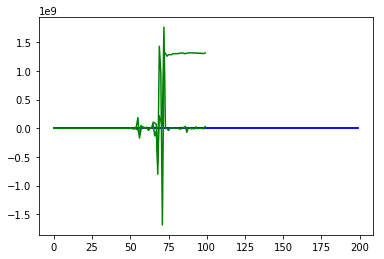

In [18]:
import matplotlib.pyplot as plt
plt.plot(car_trajectory,label = 'bot', color = 'b')
plt.plot(estimation_trajectory,label = 'kalman', color = 'g')
plt.show()